# <a href="https://miptstats.gitlhub.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 7. Кластеризация и понижение размерности

При необходимости установите библиотеку-расширение для `plotly`, позволяющую рисовать картинки на всплывающих окнах.

    pip install dash

In [1]:
!pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 41.2 MB/s eta 0:00:00


In [2]:
import io
import os
import base64

import numpy as np
import pandas as pd
from tqdm.cli import tqdm
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, no_update, callback

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch
from transformers import ViTImageProcessor, ViTModel

sns.set_theme(style="darkgrid", palette="Set2")

---
### Задача 1.

Докажите, что метод KMeans делит все пространство объектов на выпуклые многоугольники, возможно, неограниченные.

**Центроиды как центры кластеров**: В методе KMeans каждый кластер представлен своим центроидом, который является средним значением всех точек кластера. Центроиды располагаются в центрах масс кластеров.

**Минимизация суммарного квадратичного расстояния:** При выполнении алгоритма KMeans центроиды перемещаются таким образом, чтобы минимизировать суммарное квадратичное расстояние от точек кластера до их центроидов. Это означает, что каждая точка в кластере ближе к своему центроиду, чем к центроидам других кластеров.

**Построение выпуклых областей:** Из-за характера минимизации суммарного квадратичного расстояния каждая точка в кластере будет находиться ближе к своему центроиду, чем к центроидам других кластеров. Это приводит к тому, что области, в которых все точки ближе к определенному центроиду, образуют выпуклые многогранники.

**Возможность неограниченных многоугольников:** Поскольку алгоритм KMeans не ограничивает форму кластеров, а только минимизирует суммарное квадратичное расстояние, многогранники могут быть неограниченными, если данные или параметры алгоритма не препятствуют этому.

Таким образом, метод KMeans разбивает пространство объектов на выпуклые многогранники, и эти многогранники могут быть неограниченными в зависимости от данных и параметров алгоритма.

---
### Задача 2.

Как мы знаем, в пространствах большой размерности расстояния между случайными объектами становятся неинформативными. Эта проблема известна как *проклятие размерности*, и она влечет соответствующие ограничения на использование методов, основанных на использовании расстоянии между объектами.

В этой задаче предлагается промоделировать ситуацию понижения размерности. Сгенерируйте достаточно большое количество точек в единичном кубе в пространстве некоторой размерности.

In [3]:
sample_size = 1000

Повторим генерацию для нескольких размерностей пространства от 2 до 1000. Используем не менее 7 различных значений размерностей пространства.

In [5]:
# получили по 50 точек в пространстве размерностей от 2 до 1000
dims = np.arange(2, 500, 50)
samples = [np.random.uniform(size=(sample_size, dim)) for dim in dims]

In [6]:
len(dims)

10

Для каждой размерности посчитайте норму каждой точки, тем самым получая набор значений расстояния от 0 до случайной точки. Нормируем все расстояния, поделив на среднее полученных расстояний для каждой размерности пространства.

In [7]:
# считаем норму каждой точки
dists = [np.linalg.norm(samples[i][j], ord=2) for i, j in itertools.product(range(len(dims)), range(len(samples[0])))]
dists = np.array_split(dists, len(dists) // 1000)

# нормируем расстояния
norms = [dists[i] / np.mean(dists[i]) for i in range(len(dists))]

Нарисуем на одном графике KDE-оценки плотности нормированных расстояний для каждой размерности пространства.

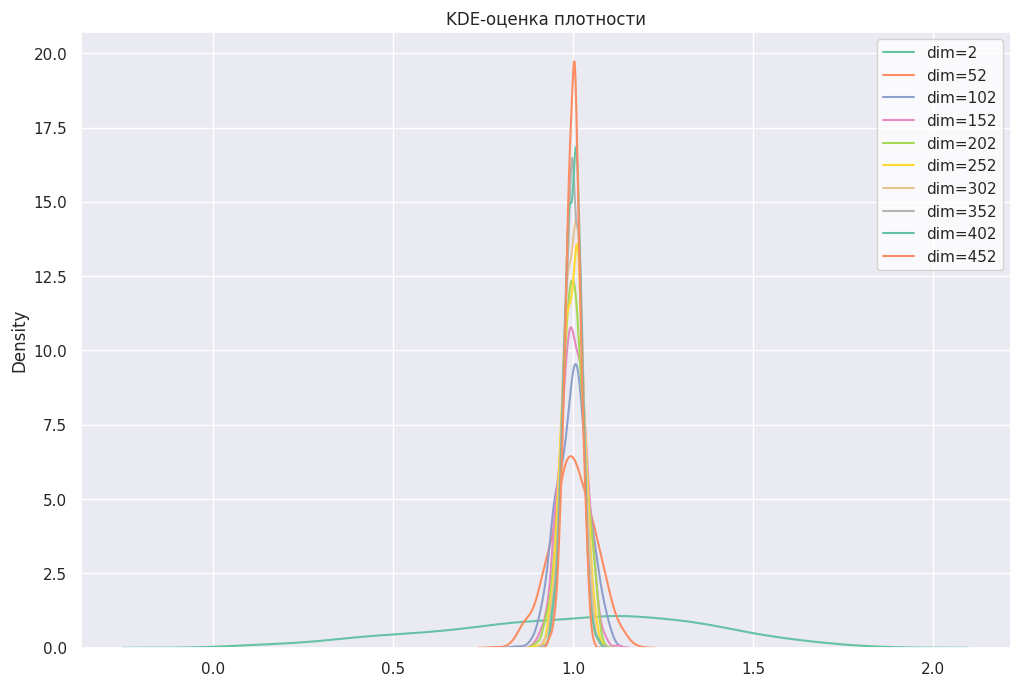

In [8]:
plt.figure(figsize=(12, 8))
with sns.axes_style("darkgrid"):
  for i in range(len(dims)):
    ax = sns.kdeplot(norms[i], label=f"dim={dims[i]}")
  ax.set_title("KDE-оценка плотности");
  ax.legend().get_frame().set_facecolor("white");

**Выводы**:
- Мы встретились с проклятием размерности
- Поскольку мы изучаем метрический метод, то повышение размерности пространства приводит к неинформативности функции расстояния.
- для работы с многопараметрическими данными стоит использовать методы, которые устойчивы к проклятию размерности. Например, PCA.

---
### Задача 3.

В этой задаче мы попробуем кластеризовать различными способами изображения котиков из датасета.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# после единаразового запуска кода на вашем диске уже будет разархивированный файл
#!unzip /content/drive/MyDrive/Data_science/cats.zip -d /content/drive/MyDrive/Data_science/cats_photo/

In [25]:
# Загружаем картинки
cats_path = "/content/drive/MyDrive/Data_science/cats_photo/cats"
cats = []
for filename in os.listdir(cats_path):
    cats.append(plt.imread(os.path.join(cats_path, filename)))

Размерность cats: (15747, 12288)


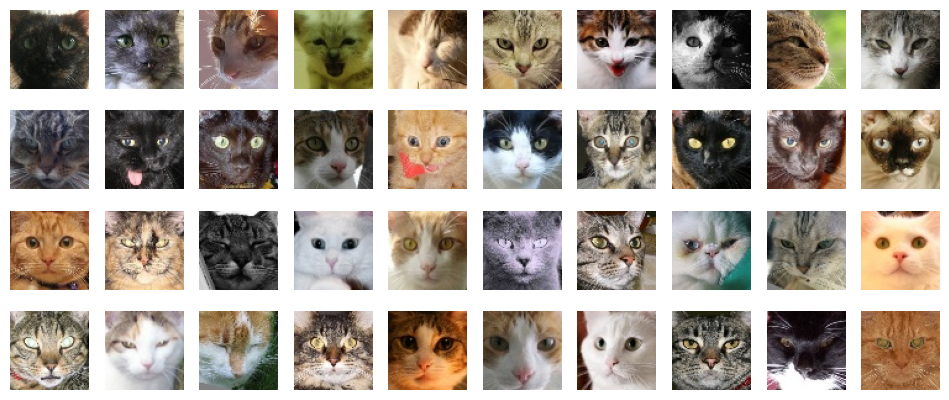

In [26]:
cats = np.stack(cats).reshape(-1, 64 * 64 * 3)
print(f"Размерность cats: {cats.shape}")

# Визуализируем примеры
plt.figure(figsize=(12, 5))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(cats[i].reshape(64, 64, 3))
    plt.axis("off")

#### 1. Свойства метрики в пространстве котиков

Прежде всего давайте исследуем, наблюдается ли проблема проклятия размерности в пространстве котиков, фактически повторив исследование предыдущей задачи. Для этого выберите не менее 10000 случайных пар изображений и посчитайте расстояния между ними. Визуализируйте KDE-оценку плотности нормированных расстояний.

Повторите те же действия к результату применения PCA, рассмотрев разное количество компонент, например, для 30, 100 и 500. Обратите внимание, что PCA нужно обучать на всех изображениях, а не только для тех, для которых вы будете считать расстояния.

In [35]:
# выберем 10000 случайных пар изображений
rng1 = np.random.default_rng()
rand_index1 = rng1.integers(low=100, high=len(cats) - 1, size=10000)
rand_index2 = rng1.integers(low=1000, high=len(cats) - 1, size=10000)
pairs = np.array([cats[i] - cats[j] for i, j in zip(rand_index1, rand_index2)])

# посчитаем расстояние между ними
dists = np.array([np.linalg.norm(pairs[i], ord=2) for i in range(len(pairs))])

# нормируем расстояния
norm_dists = [dists[i] / np.mean(dists) for i in range(len(dists))]

In [34]:
pairs.shape

(10000, 12288)

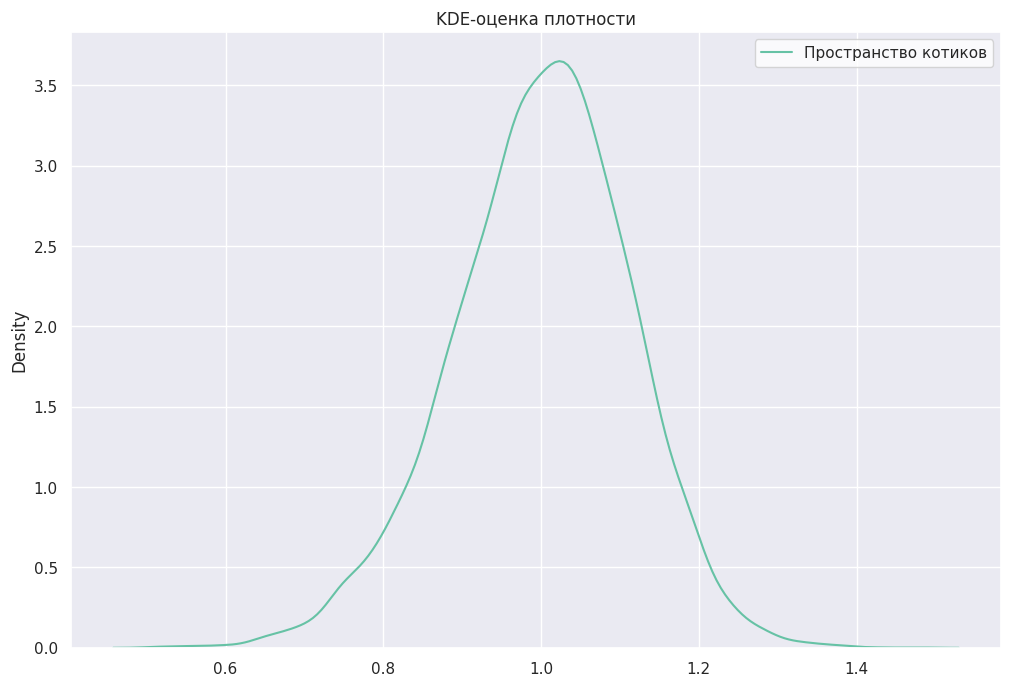

In [36]:
# визуализируем KDE-оценку плотности
plt.figure(figsize=(12, 8))
with sns.axes_style("darkgrid"):
  ax = sns.kdeplot(norm_dists, label=f"Пространство котиков")
  ax.set_title("KDE-оценка плотности");
  ax.legend().get_frame().set_facecolor("white");

Повторим те же действия к результату применения PCA, рассмотрев разное количество компонент, например 30, 100 и 500.

In [37]:
components = [30, 100, 500]
pca = [PCA(n_components=i) for i in components]
cats_projection = [pca[i].fit_transform(pairs.astype(np.float32)) for i in range(len(pca))]
print(f"Размерность проекции c 30 компонентами: {cats_projection[0].shape}")
print(f"Размерность проекции c 100 компонентами: {cats_projection[1].shape}")
print(f"Размерность проекции c 500 компонентами: {cats_projection[2].shape}")

Размерность проекции c 30 компонентами: (10000, 30)
Размерность проекции c 100 компонентами: (10000, 100)
Размерность проекции c 500 компонентами: (10000, 500)


In [50]:
dists = np.array([[np.linalg.norm(cats_projection[i][j], ord=2) for j in range(len(cats_projection[0]))] for i in range(len(cats_projection))])
norm_dists = np.array([[dists[i][j] / np.mean(dists[i]) for j in range(dists.shape[1])] for i in range(dists.shape[0])])

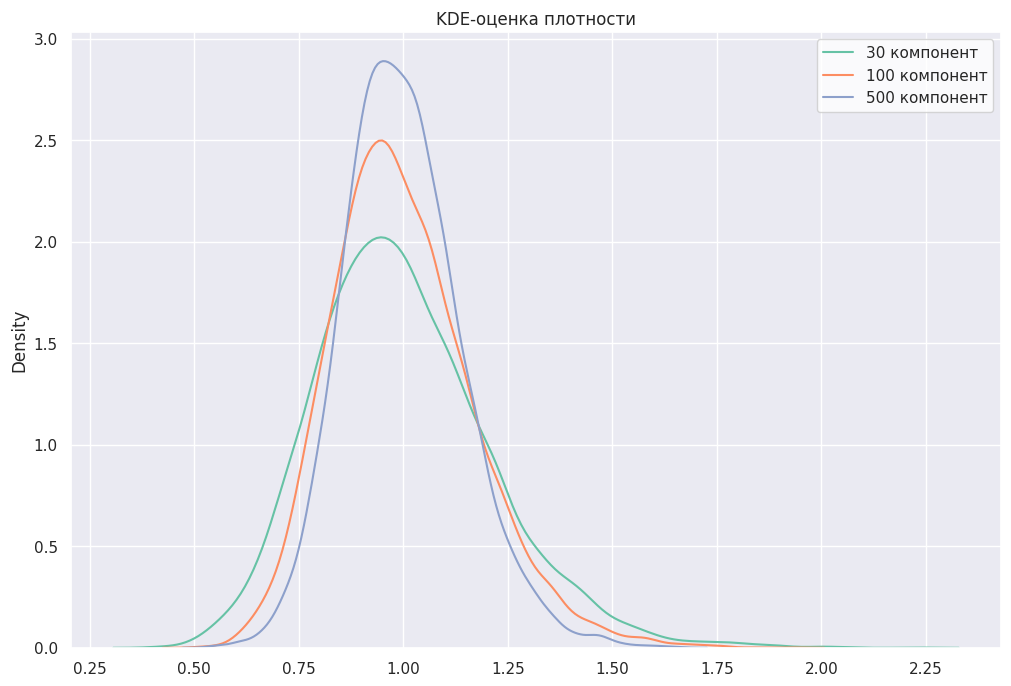

In [54]:
# визуализируем KDE-оценку плотности
plt.figure(figsize=(12, 8))
with sns.axes_style("darkgrid"):
  for i in range(len(pca)):
    ax = sns.kdeplot(norm_dists[i], label=f"{components[i]} компонент")
  ax.set_title("KDE-оценка плотности");
  ax.legend().get_frame().set_facecolor("white");


**Выводы:**
- Из графика видно, что PCA много лучше справляется с пространством больших размерностей: не возникает узких, высоких пиков. Таким образом мы убедились, что проблема проклятия размерности решена.
- Этот метод можно применять к всевозможным объектам, лишь бы их можно было перевести в числа. Например, изображения представимы в виде матриц, а значит метод PCA можно к ним применить.

#### 2. Кластеризация котиков по вектору изображения

Начнем эксперименты с самого простого способа: каждое изображение можно вытянуть в вектор размерности $64 \cdot 64 \cdot 3$, их и попытаемся кластеризовать. Обучим по этим объектам метод KMeans.

In [55]:
N_CLUSTERS = 4

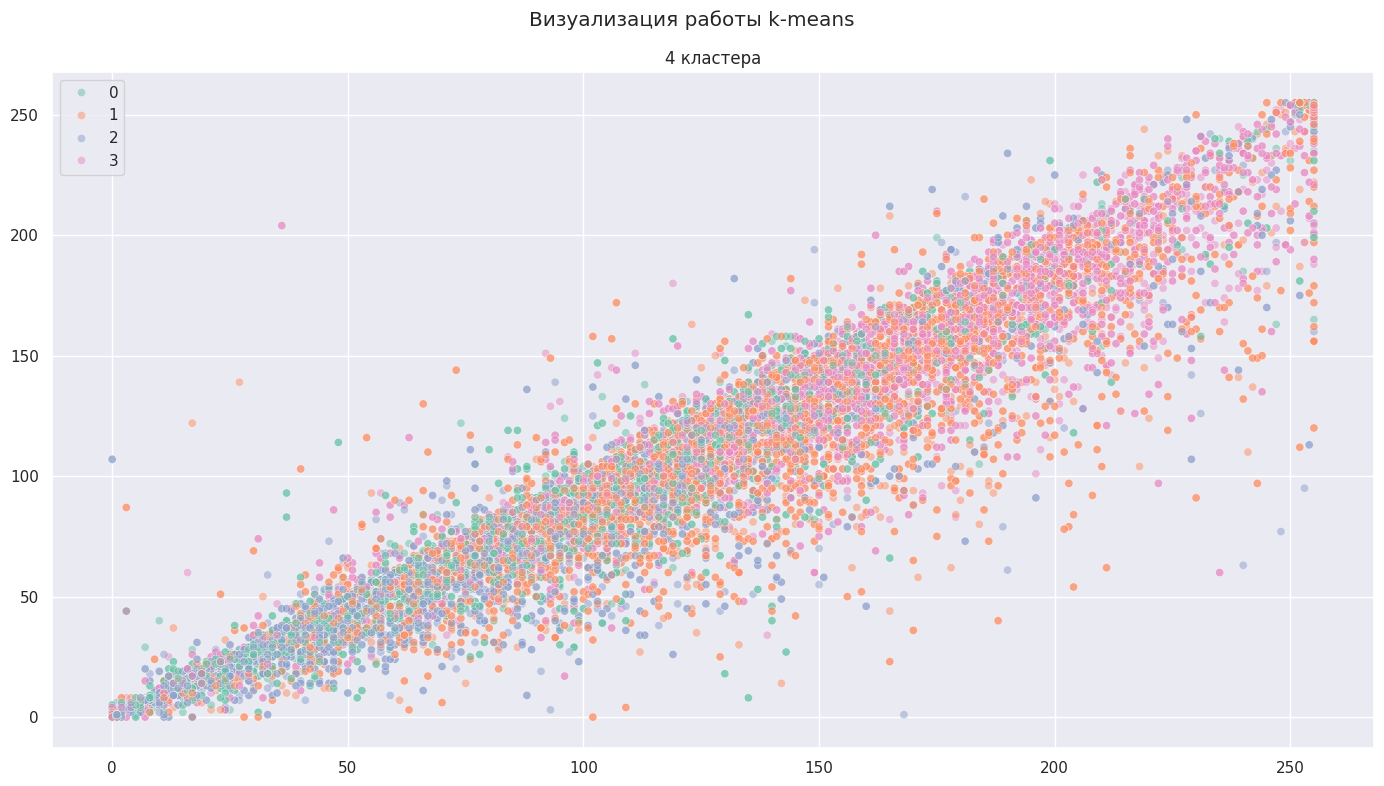

CPU times: user 42.5 s, sys: 4.08 s, total: 46.6 s
Wall time: 33.6 s


In [56]:
%%time
fig = plt.figure(figsize=(14, 8))
fig.suptitle("Визуализация работы k-means")

# Предсказание
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init="auto", random_state=42)
kmeans.fit(cats)
y_pred = kmeans.predict(cats)

# Визуализация
sns.scatterplot(x=cats[:, 0], y=cats[:, 1], hue=y_pred, alpha=0.5, palette="Set2")
plt.title(f"{N_CLUSTERS} кластера")

plt.tight_layout()
plt.show()

Теперь отобразим изображения на плоскость с помощью PCA и визуализируем полученные предсказания цветом. Ниже реализована функция отрисовки `visualize_images_clusterisation`.

In [15]:
def visualize_images_clusterisation(images, projection, clusters, port=None):
    """
    Визуализиует двумерную проекцию эмбеддингов изображений,
    во всплывающем окне показывает сами изображения

    :param images: набор изображений
    :param projection: двумерная проекция изображений или эмбеддингов изображений
    :param clusters: предсказанные кластера
    :param port: опциональный параметр, порт на котором поднимается визуализация:
                 одинаковые порты - одинаковые графики, но если в ноутбуке открыто много портов, то могут начаться лаги
    """
    # Рисуем график с точками как на семинаре
    fig = px.scatter(
        x=projection[:, 0],
        y=projection[:, 1],
        hover_name=clusters,
        hover_data={"image_idx": list(range(len(images)))},
        color=clusters.astype(str),
        width=1000,
        height=800,
        title="PCA проекция изображений на плоскость",
        size=[1] * len(images),
        size_max=12,
    )

    # Добавляем во всплывающее окошко (hover box) изображения
    fig.update_traces(
        hoverinfo="none",
        hovertemplate=None,
    )

    app = Dash(__name__)

    app.layout = html.Div(
        className="container",
        children=[
            dcc.Graph(id="graph-2-dcc", figure=fig, clear_on_unhover=True),
            dcc.Tooltip(id="graph-tooltip-2", direction="bottom"),
        ],
    )

    @callback(
        Output("graph-tooltip-2", "show"),
        Output("graph-tooltip-2", "bbox"),
        Output("graph-tooltip-2", "children"),
        Output("graph-tooltip-2", "direction"),
        Input("graph-2-dcc", "hoverData"),
    )
    def display_hover(hoverData):
        """
        Настраивает всплывающее окно hover box.

        :param hoverData: данные соответствующей точки
        """
        if hoverData is None:
            return False, no_update, no_update, no_update

        # Достаем индекс картинки, который выше положили в hover_data
        hover_data = hoverData["points"][0]
        image_idx = hover_data["customdata"][0]
        # И получаем само изображение кота
        image = Image.fromarray(images[image_idx].reshape(64, 64, 3))

        # Преобразовываем изображение в base64 кодировку
        buffer = io.BytesIO()
        image.save(buffer, format="jpeg")
        encoded_image = base64.b64encode(buffer.getvalue()).decode()
        image_url = "data:image/jpeg;base64, " + encoded_image

        image_children = [
            html.Img(
                src=image_url,
                style={"width": "196px"},
            ),
        ]

        return True, hover_data["bbox"], image_children, "top"

    if port is None:
        port = str(np.random.randint(5000, 15000))
    app.run(port=port, debug=True, jupyter_height=800)

    return app

In [62]:
pca = PCA(n_components=30)
cats_projection = pca.fit_transform(cats.astype(np.float32))

In [63]:
# отобразим изображения на плоскость с помощью PCA
visualize_images_clusterisation(cats, cats_projection, y_pred)   # 30 компонент

<IPython.core.display.Javascript object>

Для каждого кластера нарисуем по 5-10 типичных изображений, то есть ближайших к центру кластера.

In [78]:
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_
# занесем точки, принадлежащие одному кластеру в массивы
clusters = [[], [], [], []]
for i in range(len(cats)):
  if (labels[i] == 0):
    clusters[0].append(cats[i])
  elif (labels[i] == 1):
    clusters[1].append(cats[i])
  elif (labels[i] == 2):
    clusters[2].append(cats[i])
  else:
    clusters[3].append(cats[i])

# Считаем расстояния до центра от каждой точки кластера
distances = [np.linalg.norm(cluster_centers[i] - clusters[i], axis=1) for i in range(len(cluster_centers))]
# Сортируем расстояния и берем индексы в порядке возрастания расстояний
closest_idxs = [np.argsort(distances[i]) for i in range(len(cluster_centers))]
# Берем топ-5 уникальных ответов, соответствующих полученным индексам
closest_answers = [np.take(cats, closest_idxs[i])[:5] for i in range(len(cluster_centers))]

Каждая строка отвечает за свой кластер. Выведем 5 ближайших картинок к центру кластера.


<Figure size 2000x1700 with 0 Axes>

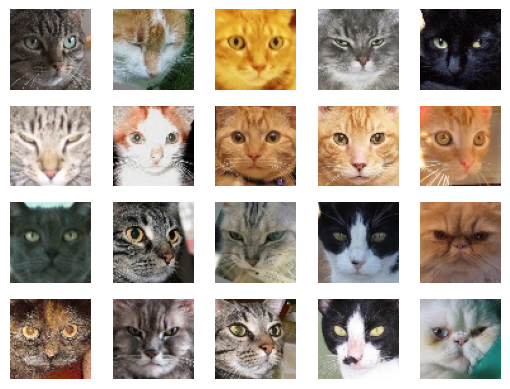

In [79]:
# выводим изображения
plt.figure(figsize=(20, 17))
fig, ax = plt.subplots(nrows=len(cluster_centers), ncols=len(closest_answers[0]))
for i in range(len(cluster_centers)):
  # ax[i, 0].set_xlabel(f"Кластер {i}")
  for j in range(len(closest_answers[i])):
    ax[i, j].imshow(cats[closest_answers[i][j]].reshape(64, 64, 3))
    ax[i, j].axis("off")

print("Каждая строка отвечает за свой кластер. Выведем 5 ближайших картинок к центру кластера.")

Наблюдаются ли какие-то закономерности в изображениях внутри одного кластера? Если да, то опишите отличительные черты кластеров.

$\textbf{Ответ:}$
- Сильно выделяется изображения из второго кластера (строка 2). Изображения оттуда находятся в желтом спектре. Кроме того, глаза котов сильно раскрыты.
- Третий кластер (строка 3) содержит как будто более блеклые изображения,
- Изображения 4-го кластера, наверное, имеют в среднем хороший баланс белого с некоторым ярковыраженным световым пятном на носе кота.
- Изображения 1-го кластера могли отбираться по остаточному признаку. Явных особенностей выделить не смог.

Подумайте, чем может быть плох такой подход? Какая проблема могла возникнуть и возникла ли? Обратите внимание на проведенное ранее исследование.

$\textbf{Ответ:}$
- во-первых трудность этого подхода в том, чтобы подобрать оптимальное количество компонент, так как раскладывая на правильные компоненты мы впоследствии лучше классифицируем изображения.
- во-вторых, как понять, что на сколько кластеров разбивать множество объектов? От этого гиперпараметра многое зависит, и никак, кроме разве что эмперического подхода, мы подобрать его значение на этом этапе не можем.


#### 3. PCA + кластеризация

Попробуем уменьшить размерность перед кластеризацией с помощью PCA, спроектировав изображения на первые несколько главных компонент

**Примечание.** Не стоит брать больше 100 главных компонент

Сделаем кластеризацию:

In [101]:
%%time
N_CLUSTERS = 4

# применим PCA к векторам
pca_claster = PCA(n_components=20)
cats_projection_claster = pca_claster.fit_transform(cats.astype(np.float32))

# сделаем кластеризацию на проекциях
kmeans_pca = KMeans(n_clusters=N_CLUSTERS, n_init="auto", random_state=42)
kmeans_pca.fit(cats_projection_claster)
y_pred_pca = kmeans_pca.predict(cats_projection_claster)

CPU times: user 20.3 s, sys: 6.03 s, total: 26.3 s
Wall time: 21.2 s


Посмотрим, насколько совпадают предсказания у двух методов.

In [102]:
print(np.average(y_pred_pca == y_pred))

0.0006350415952244872


Визуализируем полученные кластера:

In [103]:
visualize_images_clusterisation(cats, cats_projection_claster, y_pred_pca)   # 20 компонент

<IPython.core.display.Javascript object>

Нарисуем по 5-10 типичных изображений для новых кластеров

Каждая строка отвечает за свой кластер. Выведем 5 ближайших картинок к центру кластера.


<Figure size 2000x1700 with 0 Axes>

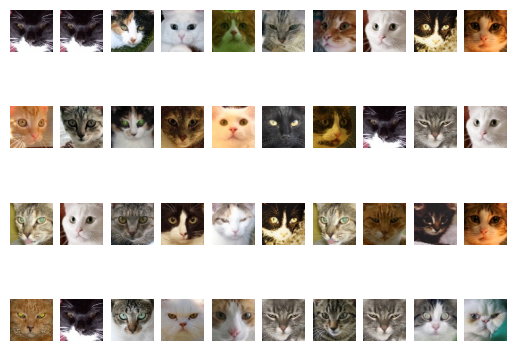

In [109]:
cluster_centers_pca = kmeans_pca.cluster_centers_
labels_pca = kmeans_pca.labels_
# занесем точки, принадлежащие одному кластеру в массивы
clusters_pca = [[], [], [], []]

for i in range(len(labels_pca)):
  if (labels_pca[i] == 0):
    clusters_pca[0].append(cats_projection_claster[i])
  elif (labels_pca[i] == 1):
    clusters_pca[1].append(cats_projection_claster[i])
  elif (labels_pca[i] == 2):
    clusters_pca[2].append(cats_projection_claster[i])
  else:
    clusters_pca[3].append(cats_projection_claster[i])

# Считаем расстояния до центра от каждой точки кластера
distances_pca = [np.linalg.norm(cluster_centers_pca[i] - clusters_pca[i], axis=1) for i in range(len(cluster_centers_pca))]
# Сортируем расстояния и берем индексы в порядке возрастания расстояний
closest_idxs_pca = [np.argsort(distances_pca[i]) for i in range(len(cluster_centers_pca))]
# Берем топ-5 уникальных ответов, соответствующих полученным индексам
closest_answers_pca = [np.take(cats, closest_idxs_pca[i])[:10] for i in range(len(cluster_centers_pca))]

# выводим изображения
plt.figure(figsize=(20, 17))
fig, ax = plt.subplots(nrows=len(cluster_centers_pca), ncols=len(closest_answers_pca[0]))
for i in range(len(cluster_centers_pca)):
  # ax[i, 0].set_xlabel(f"Кластер {i}")
  for j in range(len(closest_answers_pca[i])):
    ax[i, j].imshow(cats[closest_answers_pca[i][j]].reshape(64, 64, 3))
    ax[i, j].axis("off")

print("Каждая строка отвечает за свой кластер. Выведем 10 ближайших картинок к центру кластера.")

Опишите отличительные черты кластеров:

$\textbf{Ответ:}$
- В 4-м кластере коты имеют преимущественно серую расцветку.
- В 1-ый кластер попали изображения, имеющие нарушенный баланс цветов.
- В 3-м и во 2-м кластерах сложно выявить закономерность.

Сильно ли они отличаются от предыдущего способа?

$\textbf{Ответ:}$
- Да, можно наблюдать сильное различие между этими двумя методами. По итогу мы получили соответствие лишь в $\approx 22\%$! Это показывает, что PCA действительно влияет на кластеризацию.

Можно заметить, что одно изображение ошибочно попадает в разные кластеры. Это может быть связано с тем, что оно равноудалено от центров этих кластеров.

#### 4. Нейросетевые эмбеддинги + кластеризация

Попробуем применить к изображениям такой же подход, как с текстами. То есть возьмем хорошую уже обученную нейросеть, получим с ее помощью эмбеддинги изображений и будем дулеть кластеризацию этих эмбеддингов.

Выберите на <a target="_blank" href="https://huggingface.co/models">huggingface</a> модель для получения эмбеддингов изображений.

**Примечания**
- Нам нужны `CV` модели для задачи извлечения признаков (в фильтрах huggingface называются `Image Feature Extraction`).
- Не выбирайте слишком тяжелые модели (с суффиксами `-huge`, `-giant`, `-large` и прочим), нам это ни к чему, так как картинки маленькие и простые. К тому же это замедлит предсказание эмбеддингов.
- Обычно в карточке модели есть пример применения, который можно скопировать и как в семинаре в цикле применить ко всем батчам изображениям.
- Некоторые модели могут возвращать не эмбеддинг размерности `(D,)`, а матрицу признаков размерности `(n, D)`, в этому случае надо применить average-pooling, усреднив по предпоследней оси.

Загрузим модель, применим к одному тестовому изображению кота и посмотрим на размерность полученного тензора.

In [7]:
example_image = cats[0].reshape(64, 64, 3)

# Загрузка и тестовое применение модели
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small')
model = AutoModel.from_pretrained('facebook/dinov2-small')

inputs = processor(images=example_image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Теперь применим загруженную модель ко всем картинкам.

In [8]:
cats_reshape = [cats[i].reshape(64, 64, 3) for i in range(1500)]

При обучении возникала проблема нехватки RAM. Чтобы ее решить будем обучаться на батчах.

In [9]:
batches = [cats_reshape[10 * i: 10 * i + 10] for i in range(len(cats_reshape) // 10)]

In [10]:
hidden_states = []
for batch in batches:
    inputs = processor(images=batch, return_tensors="pt")
    with torch.no_grad():
      outputs = model(**inputs)
    hidden_states.append(outputs.last_hidden_state.mean(axis = 1))

In [11]:
# объединим данные
embeddings = torch.cat(hidden_states, dim=0)
print(embeddings.shape)

torch.Size([1500, 384])


Сделаем кластеризацию полученных эмбеддингов.

In [36]:
kmeans = KMeans(n_clusters=4, n_init="auto", random_state=42)
y_pred_nn = kmeans.fit_predict(embeddings)

Визуализируем полученные кластера:

In [48]:
# применим PCA к векторам
cats_im = cats[:1500]
pca_nn = PCA(n_components=20)
cats_projection_nn = pca_nn.fit_transform(embeddings.numpy().astype(np.float32))

visualize_images_clusterisation(cats_im, cats_projection_nn, y_pred_nn)   # 20 компонент

<IPython.core.display.Javascript object>

Нарисуем по 5-10 типичных изображений для новых кластеров.

Каждая строка отвечает за свой кластер. Выведем 10 ближайших картинок к центру кластера.


<Figure size 2000x1700 with 0 Axes>

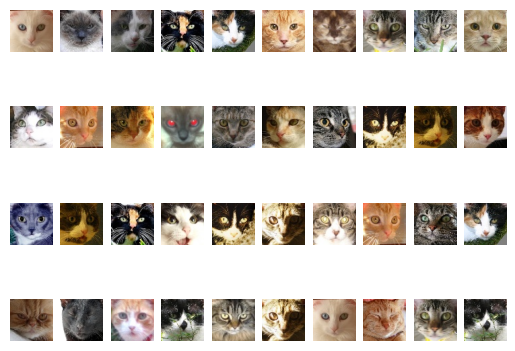

In [51]:
cluster_centers_nn = pca_nn.transform(kmeans.cluster_centers_.astype(np.float32))
# cluster_centers_nn = pca_nn.transform(embeddings.numpy().astype(np.float32))

labels_nn = kmeans.labels_
# занесем точки, принадлежащие одному кластеру в массивы
clusters_nn = [[], [], [], []]

for i in range(len(labels_nn)):
  if (labels_nn[i] == 0):
    clusters_nn[0].append(cats_projection_nn[i])
  elif (labels_nn[i] == 1):
    clusters_nn[1].append(cats_projection_nn[i])
  elif (labels_nn[i] == 2):
    clusters_nn[2].append(cats_projection_nn[i])
  else:
    clusters_nn[3].append(cats_projection_nn[i])

# Считаем расстояния до центра от каждой точки кластера
distances_nn = [np.linalg.norm(cluster_centers_nn[i] - clusters_nn[i], axis=1) for i in range(len(cluster_centers_nn))]
# Сортируем расстояния и берем индексы в порядке возрастания расстояний
closest_idxs_nn = [np.argsort(distances_nn[i]) for i in range(len(cluster_centers_nn))]
# Берем топ-5 уникальных ответов, соответствующих полученным индексам
closest_answers_nn = [np.take(cats_im, closest_idxs_nn[i])[:10] for i in range(len(cluster_centers_nn))]

# выводим изображения
plt.figure(figsize=(20, 17))
fig, ax = plt.subplots(nrows=len(cluster_centers_nn), ncols=len(closest_answers_nn[0]))
for i in range(len(cluster_centers_nn)):
  # ax[i, 0].set_xlabel(f"Кластер {i}")
  for j in range(len(closest_answers_nn[i])):
    ax[i, j].imshow(cats[closest_answers_nn[i][j]].reshape(64, 64, 3))
    ax[i, j].axis("off")

print("Каждая строка отвечает за свой кластер. Выведем 10 ближайших картинок к центру кластера.")

Опишем отличительные черты кластеров:

- В 2-м кластере появилось много полосатых котов, вне зависимости от освещения.
- В 3-м кластере у котов чаще встречается белый нос

Чем отличаются кластеры, полученные этим способом от первых двух?

Сильного различия не наблюдается. Причиной этого может быть то, что в силу ограниченности времени я обучал модель лишь на 1500 изображениях.

#### 5. Выводы
Сделайте выводы:

1. В ходе работы мы убедились в существовании проблемы проклятия размерности. Сначала на синтетических данных, а потом на реальных.
2. Чтобы решить эту проблему мы понижали размерность, пользуясь методом PCA. Причем разница результатов была большой.
3. Далее мы перешли к методам кластеризации с помощью нейронных сетей. Важно заметить, что в нашем случае не было необходимости пользоваться большой нейросетью, вследствие легкости задачи. Результаты ее работы были самыми хорошими.